## Задача 5-1. A\* поиск в задаче о кратчайших путях.

В этой задаче Вам предлагается реализовать поиск кратчайших путей в графе с помощью A\*-поиска с использованием эвристической функции («потенциала»), основанном на landmarks. Теоретические основы можно посмотреть [здесь](http://logic.pdmi.ras.ru/midas/sites/default/files/midas-werneck.pdf), слайды 20—36.

Вам предлагается скачать [отсюда](http://www.diag.uniroma1.it/challenge9/download.shtml) файлы “Travel time graph” и “Coordinates” для штата Флорида. Для Вашего удобства они также размещены в архиве `florida.7z` в настоящем репозитории на GitHub.

Функции `read_node_coords` и `read_arcs` возвращают соответственно координаты вершин графа (отнормированные; координаты нужны только для обеспечения возможности выбора landmarks “по периметру графа”) и структура дуг графа.

In [1]:
import math
from typing import List, Dict, Tuple
from collections import namedtuple, defaultdict
Coords = namedtuple('Coords', ['x', 'y'])

def read_node_coords(filename='USA-road-d.FLA.co') -> List[int]:
    node_coords = []
    
    with open(filename, 'r') as coord_file:
        for line in coord_file:
            if line.startswith('v '):
                node_number, x, y = map(int, line.split()[1:])
                node_coords.append(Coords(x, y))
    
    minx = min(c.x for c in node_coords)
    miny = min(c.y for c in node_coords)
    for i, c in enumerate(node_coords):
        node_coords[i] = Coords(c.x-minx, c.y-miny)
    
    return node_coords


def read_arcs(filename='USA-road-t.FLA.gr') -> Dict[int, Dict[int, float]]:
    adjacency_lists = defaultdict(dict)
    
    with open(filename, 'r') as coord_file:
        for line in coord_file:
            if line.startswith('a '):
                node_from, node_to, weight = map(int, line.split()[1:])
                adjacency_lists[node_from-1][node_to-1] = weight
                
    return adjacency_lists

Реализуйте процедуру `good_old_dijkstra`, которая для пары номеров вершин графа ищет кратчайший путь между ними и возвращает список номеров вершин, образующих оптимальный путь и его длину.

In [2]:
import queue

In [3]:
def dijkstra_to_all(adjacency_lists: Dict[int, Dict[int, float]], node_from) -> Tuple[List[int], Dict[int, int], Dict[int, float]]:
    q = queue.PriorityQueue()
    p = {}
    for v in adjacency_lists:
        p[v] = -1
    d = {}
    inf = 1e18
    for v in adjacency_lists:
        d[v] = inf
    d[node_from] = 0
    q.put((0, node_from))
    while not q.empty():
        dist, cur = q.get()
        for v in adjacency_lists[cur]:
            edge_len = adjacency_lists[cur][v]
            if dist + edge_len < d[v]:
                d[v] = dist + edge_len
                p[v] = cur
                q.put((dist + edge_len, v))
    return (p, d)

In [4]:
def good_old_dijkstra(adjacency_lists: Dict[int, Dict[int, float]], node_from, node_to) -> Tuple[List[int], float]:
    p, d = dijkstra_to_all(adjacency_lists, node_from)
    cur = node_to
    path = []
    while cur != -1:
        path.append(cur)
        cur = p[cur]
    path.reverse()
    return (path, d[node_to])

In [5]:
%%time
adj = read_arcs()
coords = read_node_coords()

CPU times: user 23.6 s, sys: 568 ms, total: 24.2 s
Wall time: 24.6 s


In [6]:
%%time
good_old_dijkstra(adj, 123456, 234567)

CPU times: user 25.8 s, sys: 220 ms, total: 26 s
Wall time: 26.1 s


([123456,
  123455,
  118458,
  118441,
  118440,
  118438,
  118420,
  104123,
  104149,
  104150,
  122145,
  122144,
  122143,
  122142,
  80233,
  79543,
  78330,
  78327,
  74014,
  103068,
  103056,
  103055,
  90064,
  103057,
  103062,
  90084,
  103072,
  103085,
  103086,
  103106,
  103105,
  90299,
  90352,
  103173,
  119254,
  90668,
  103174,
  90681,
  90799,
  103181,
  90876,
  90898,
  103184,
  103183,
  92905,
  103224,
  92961,
  103253,
  103256,
  103274,
  92972,
  93159,
  93156,
  93160,
  93204,
  93206,
  118672,
  118671,
  118670,
  118669,
  118668,
  118667,
  118666,
  118664,
  118663,
  118662,
  118665,
  118661,
  118660,
  93139,
  93102,
  118657,
  118659,
  118658,
  118656,
  118655,
  118654,
  118653,
  118652,
  118651,
  93026,
  93023,
  92995,
  92993,
  92647,
  92646,
  92628,
  92619,
  115896,
  92567,
  92472,
  92468,
  92467,
  92466,
  91607,
  91608,
  91604,
  91606,
  91559,
  91558,
  91553,
  91552,
  91549,
  91219,
  91214

Реализуйте тройку процедур `choose_landmarks`, `precalculate_landmark_distances` и `a_star_with_landmarks`. Процедура `choose_landmarks` выбирает нужное количество специальных вершин графа — этот выбор делается равномерным выбором по периметру графа (см. слайд 30 в [презентации](http://logic.pdmi.ras.ru/midas/sites/default/files/midas-werneck.pdf)). Процедура `precalculate_landmark_distances` для каждой вершины из заданного набора с помощью обычного алгоритма Дейкстры вычисляет расстояния до всех вершин графа. Эта информация затем используется в `a_star_with_landmarks` для ускорения поиска кратчайшего пути.

In [7]:
import math

In [20]:
def choose_landmarks(node_coords, num_landmarks=15) -> List[int]:
    def dist(v, u):
        return math.sqrt((v.x - u.x) ** 2 + (v.y - u.y) ** 2)
    
    mean_x = sum([v.x for v in node_coords]) / len(node_coords)
    mean_y = sum([v.y for v in node_coords]) / len(node_coords)
    sectors = [[] for i in range(num_landmarks)]
    for i in range(len(node_coords)):
        v = node_coords[i]
        alpha = math.atan2(v.x - mean_x, v.y - mean_y)
        if alpha < 0:
            alpha += 2 * math.pi
        our_sector = int(alpha * num_landmarks / (2 * math.pi))
        sectors[our_sector].append((v, i))
    landmarks = []
    for sector in sectors:
        assert(len(sector) > 0)
        furthest = sector[0][0]
        for v, i in sector:
            if dist(v, Coords(mean_x, mean_y)) < dist(furthest, Coords(mean_x, mean_y)):
                furthest = v
        landmarks.append(i)
    return landmarks

def precalculate_landmark_distances(adjacency_lists: Dict[int, Dict[int, float]], landmarks: List[int]) -> Dict[int, Dict[int, float]]:
    dist_lists = {}
    for i in range(len(landmarks)):
        dist_lists[i] = dijkstra_to_all(adjacency_lists, landmarks[i])[1]
    return dist_lists
        

def a_star_with_landmarks(adjacency_lists: Dict[int, Dict[int, float]], node_from, node_to, landmark_distances: Dict[int, Dict[int, float]]) -> Tuple[List[int], float]:
    def est_to_end(v):
        res = 0
        for L in landmark_distances:
            res = max(res, abs(landmark_distances[L][v] - landmark_distances[L][node_to]))
        return res
    
    q = queue.PriorityQueue()
    p = {}
    for v in adjacency_lists:
        p[v] = -1
    d = {}
    true_d = {}
    inf = 1e18
    for v in adjacency_lists:
        d[v] = inf
    d[node_from] = 0
    true_d[node_from] = 0
    q.put((0, node_from))
    while not q.empty():
        dist, cur = q.get()
        if cur == node_to:
            break
        for v in adjacency_lists[cur]:
            edge_len = adjacency_lists[cur][v]
            pi_v = est_to_end(v)
            if true_d[cur] + edge_len + pi_v < d[v]:
                d[v] = true_d[cur] + edge_len + pi_v
                true_d[v] = true_d[cur] + edge_len
                p[v] = cur
                q.put((d[v], v))
    cur = node_to
    path = []
    while cur != -1:
        path.append(cur)
        cur = p[cur]
    path.reverse()
    return (path, true_d[node_to])

In [9]:
%%time
node_coords = read_node_coords()
adjacency_lists = read_arcs()

CPU times: user 24.1 s, sys: 436 ms, total: 24.5 s
Wall time: 24.9 s


In [17]:
%%time
landmarks = choose_landmarks(node_coords)
landmark_distances = precalculate_landmark_distances(adjacency_lists, landmarks)
print(landmarks)

[1047900, 1014053, 1014100, 1014104, 965853, 905971, 864176, 943320, 943316, 831056, 831041, 787520, 1065520, 1070296, 1070375]


In [11]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

Попробуем визуализировать выбранные landmarks

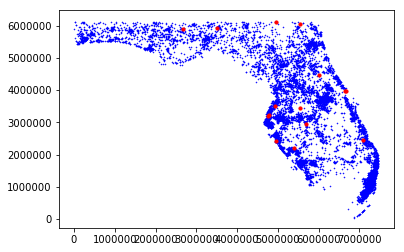

In [12]:
V = random.sample(node_coords, 10000)
plt.scatter([v.x for v in V], [v.y for v in V], color='b', s=0.3)
plt.scatter([node_coords[i].x for i in landmarks], [node_coords[i].y for i in landmarks], color='r', s=10)

Для удобства весь предподсчет я вынес наверх

In [21]:
import time
from random import randrange

def run_all():
    '''node_coords = read_node_coords()
    adjacency_lists = read_arcs()
    num_nodes = len(node_coords)
    
    time_start = time.monotonic()
    landmark_distances = precalculate_landmark_distances(adjacency_lists, choose_landmarks(node_coords))
    print('Precalculation done in {:.2} seconds.'.format(time.monotonic() - time_start))'''
    
    time_dijkstra = 0
    time_a_star = 0
    
    num_tests = 100
    num_nodes = len(node_coords)
    for _ in range(num_tests):
        node_from, node_to = randrange(num_nodes), randrange(num_nodes)
        time_start = time.monotonic()
        path, length = good_old_dijkstra(adjacency_lists, node_from, node_to)
        time_dijkstra += time.monotonic()-time_start
        print('result of dijkstra:', length)
        print('time_dijkstra: {} s'.format(time.monotonic() - time_start))
        time_start = time.monotonic()
        path, length = a_star_with_landmarks(adjacency_lists, node_from, node_to, landmark_distances)
        print('result of a_star:', length)
        print('time_a_star: {} s'.format(time.monotonic() - time_start))
        time_a_star += time.monotonic()-time_start
        print()
    
    print('Time elapsed in {} test: {:.2} second for A* vs. {:.2} seconds for Dijkstra.'.format(num_tests, time_a_star, time_dijkstra))

In [22]:
run_all()

result of dijkstra: 4153889
time_dijkstra: 26.870564361000106 s
result of a_star: 4153889
time_a_star: 7.802325252000173 s

result of dijkstra: 1803209
time_dijkstra: 26.89017229000001 s
result of a_star: 1803209
time_a_star: 1.4202595179999662 s

result of dijkstra: 4118515
time_dijkstra: 26.37678251300008 s
result of a_star: 4118515
time_a_star: 4.388210286000003 s

result of dijkstra: 1450762
time_dijkstra: 26.179330948000143 s
result of a_star: 1450762
time_a_star: 0.7681473560000995 s

result of dijkstra: 6129259
time_dijkstra: 26.906051939999998 s
result of a_star: 6129259
time_a_star: 10.485340695000104 s

result of dijkstra: 1471481
time_dijkstra: 26.685744958999976 s
result of a_star: 1471481
time_a_star: 1.294984434000071 s

result of dijkstra: 312504
time_dijkstra: 26.20004091099986 s
result of a_star: 312504
time_a_star: 1.4217931130001489 s

result of dijkstra: 2302810
time_dijkstra: 27.00475593200008 s
result of a_star: 2302810
time_a_star: 1.7520746079999299 s

result of

Видим, что алгоритм $A^*$ после предподсчета работает в среднем в 4 раза быстрее алгоритма Дейкстры, при это выдавая тот же оптимальный результат.